# 一般物体認識
 |||
 |:--:|:--:|:--:|
 |![](https://user-images.githubusercontent.com/5820803/29510276-2bed3c18-8696-11e7-8b7b-001e6fcdfd97.PNG)|![](https://user-images.githubusercontent.com/5820803/29509773-518d1d6e-8694-11e7-8a8d-b508c99eb7da.PNG)|

## 使い方
1. まず、下の箱の中でShift キーを押しながら Enterを押してください。
2. url の箱の中に認識させたい画像の URL をはりつけてください。

### 画像のURLについて
<a href="https://goo.gl/uto24t" target="_blank">Google 画像検索</a>
(右クリックして新しいウィンドウを開いてください)　などで画像を探してください。
Google の場合、画像をひとつ選んでクリック、画像右横に出る　** 「画像を表示」 ** のボタンを押してその画像のみを表示し、ブラウザ上部に表示されている URL をコピーしてください。
 
 URL の末尾が jpg や png などの画像の拡張子であることを確認してから下の url の箱にペーストしてください。
 サイトによっては画像へのアクセスが拒否される場合もあります。エラーが出た場合は別の URL  でチャレンジしてみてください。
 


In [1]:
from placenetVgg import predict,nimg00                      # ここで，SHIFT + ENTER してください
from ipywidgets import interact, interactive
interact(predict, url="https://goo.gl/FRCv7R", trans=True);

Widget Javascript not detected.  It may not be installed or enabled properly.


# グレイ化
カラー画像をモノクロ画像に変換する処理はもっとも簡単な画像処理のひとつです．

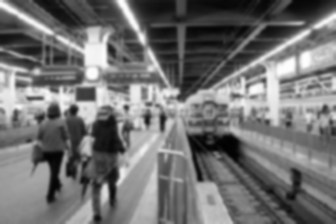

In [6]:
import cv2
from PIL import Image
gray  = cv2.cvtColor(cv2.GaussianBlur(nimg00(), (7,7), 0), cv2.COLOR_BGR2GRAY)
Image.fromarray(gray)

# 線画化
エッジ検出という画像処理を施せば線画化できます．エッジ検出はパターン認識の手掛かりをえるためのもっとも基本的な処理です．

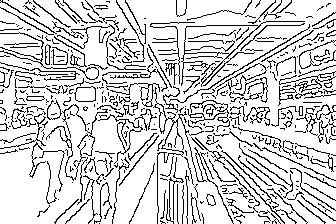

In [7]:
pic_edges = cv2.bitwise_not(cv2.Canny(gray, threshold1=20, threshold2=60))
Image.fromarray(cv2.cvtColor(pic_edges, cv2.COLOR_GRAY2RGB))

# インストラクション
モノクロ画像と線画像を右クリックしてどこかに保存してください．

- <a href="https://paintschainer.preferred.tech/index_ja.html" target="_blank"> Paint Chainer 線画の色付け</a>
- <a href="http://hi.cs.waseda.ac.jp:8082" target="_brank"> 白黒写真の自動色付け </a>

これらの処理には，いずれもディープニューラルネットワークという技術が使われています．

写真や絵の中に写っているものが何かをこたえることは皆さんには特に難しいことではありませんね。

わたしたちはパッと一目見ただけで見たものが何であるかを認識できます。例えば下の写真がどういうシーンを写したものか、誰でもすぐにわかります。

人がホームを歩いていることや、電車が停まっていることも、小さくて見えないけども時計があることもわかりますし、一番手前の人がおそらく女性であり、帽子を被っていること、傘を持っていること、だからこの日は雨だったのかな、というところまでわかります。

このようなものの認識は**一般物体認識**とよばれます。工場で決まったものをを工作するロボットや、ロボットサッカーのロボットは、それはそれでとても難しい技術から成り立っていますが、彼らは特定のものだけを見て認識したらいいだけなので、「認識」処理自体は一般物体認識と比べればとても簡単です。（それでも十分難しい。）　

最近よく話題になる自動運転でさえ、一般物体認識と比べればずいぶん簡単です。道路上にあるものだけを対象とすればいいですし、障害物かそうでないか、それがどう障害になるかだけわかればいいですから。

これまでコンピュータは**パターン認識**が苦手だとされてきました。とりわけ一般物体認識は苦手でした。

＃　ソースコード   placenetVgg.py
```
import chainer
import chainer.functions as F
from chainer import Variable
# from chainer.links import caffe
import PIL.Image
import numpy as np
import io
import urllib.request
from chainer.links.model.vision.vgg import prepare as VGGprepare

from IPython.display import clear_output, Image, display
import pickle

mean = np.array([103.939, 116.779, 123.68])   # BGR
# blob データを PIL 画像に変換
def blob2img(blob, mean=mean):
    blob = (np.dstack(blob)+ mean)[:,:,::-1]   # BGR 2 RGB
    return PIL.Image.fromarray(np.uint8(blob))

# Google 翻訳サービスを使う　ーーーーーーーーーーーーーーーーーーー
import requests
import re
 
url = 'https://translate.google.com/?hl=ja#en/ja/'
 
def translate(estring):
    r = requests.get(url, params={'q': estring})
 
    pattern = "TRANSLATED_TEXT=\'(.*?)\'"
    jstring = re.search(pattern, r.text).group(1)
 
    return jstring
# Google 翻訳サービスを使う　ーーーーーーーーーーーーーーーーーーー

# 確率リストとしての出力からトップ５を出力するメソッドーーーーーーーーーーーーー
# ILSVSR１２のカテゴリデータ　　https://raw.githubusercontent.com/CSAILVision/places365/master/categories_hybrid1365.txt
categories = np.loadtxt("categories.txt",str,delimiter='\t')
def showtop(prob, ranklimit=5, trans=True): # prob は最終層から出力される確率リスト（Variable構造体)
    top5args = np.argsort(prob.data)[:-ranklimit-1:-1] # 上位５つの番号
    top5probs = prob.data[top5args] # 上位５つの確率
    for rank,(p,words) in enumerate(zip(top5probs,categories[top5args])):
        if trans:
            print(rank+1,translate(words[2:-1]))   #  on mac
        else:
            print(rank+1,words[2:-1])
        # print(rank,translate(words)
# 確率リストとしての出力からトップ５を出力するメソッドーーーーーーーーーーーーー

# caffemodelを読み込む
# model = caffe.CaffeFunction('modeldata/vgg16_hybrid1365.caffemodel')

vgg = pickle.load(open('modeldata/vgg16_hybrid1365.pkl', 'rb'))

def url2img(url):
    print(url)
    f = io.BytesIO(urllib.request.urlopen(url).read())
    img = PIL.Image.open(f)
    w,h = img.width, img.height
    if w > h:
        w1, h1 = int(224/h * w), 224
    else :
        w1,h1 = 224, int(224/w * h)
    return img.resize((w1,h1))
    
def predict(url="", trans=True):
    img = url2img(url)
    x = Variable( VGGprepare(img)[np.newaxis,])
    y, = vgg(inputs={'data': x}, outputs=['fc8a'])
    predict = F.softmax(y)
    showtop(predict[0], trans=trans)
    return img
```

### 学習済みモデル
このプログラムでは、MITが後悔している　　place365hybrid という、一般の物体とシーンを対象とした学習済み CNN(畳み込みネットワーク）を使っています。　https://github.com/CSAILVision/places365

このネットワークは、、一般物体認識は ILSCVR とよばれるコンテストで用いられている 1000カテゴリと Place Net の 365のカテゴリを合わせた 1365 のカテゴリについて、与えられた画像の被写体である確率を出力します。このプログラムでは確率の上位5つを表示しています。
